/home/carl/MY_WORK/my_work/lib/python3.10/site-packages/sklearn/__init__.py:82: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  import scipy.linalg  # noqa
/tmp/ipykernel_3153513/1928370097.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


Epoch [1/100], Loss: 0.2060
Epoch [2/100], Loss: 0.2320
Epoch [3/100], Loss: 0.3401
Epoch [4/100], Loss: 0.3430
Epoch [5/100], Loss: 0.0597
Epoch [6/100], Loss: 0.0506
Epoch [7/100], Loss: 0.0743
Epoch [8/100], Loss: 0.3778
Epoch [9/100], Loss: 0.1875
Epoch [10/100], Loss: 0.1744
Epoch [11/100], Loss: 0.1620
Epoch [12/100], Loss: 0.0595
Epoch [13/100], Loss: 0.0574
Epoch [14/100], Loss: 0.0281
Epoch [15/100], Loss: 0.0280
Epoch [16/100], Loss: 0.1041
Epoch [17/100], Loss: 0.0483
Epoch [18/100], Loss: 0.0169
Epoch [19/100], Loss: 0.0355
Epoch [20/100], Loss: 0.0217
Epoch [21/100], Loss: 0.0305
Epoch [22/100], Loss: 0.0432
Epoch [23/100], Loss: 0.0133
Epoch [24/100], Loss: 0.0484
Epoch [25/100], Loss: 0.0639
Epoch [26/100], Loss: 0.0482
Epoch [27/100], Loss: 0.0180
Epoch [28/100], Loss: 0.0078
Epoch [29/100], Loss: 0.0350
Epoch [30/100], Loss: 0.0231
Epoch [31/100], Loss: 0.0853
Epoch [32/100], Loss: 0.0377
Epoch [33/100], Loss: 0.0617
Epoch [34/100], Loss: 0.0363
Epoch [35/100], Loss: 0

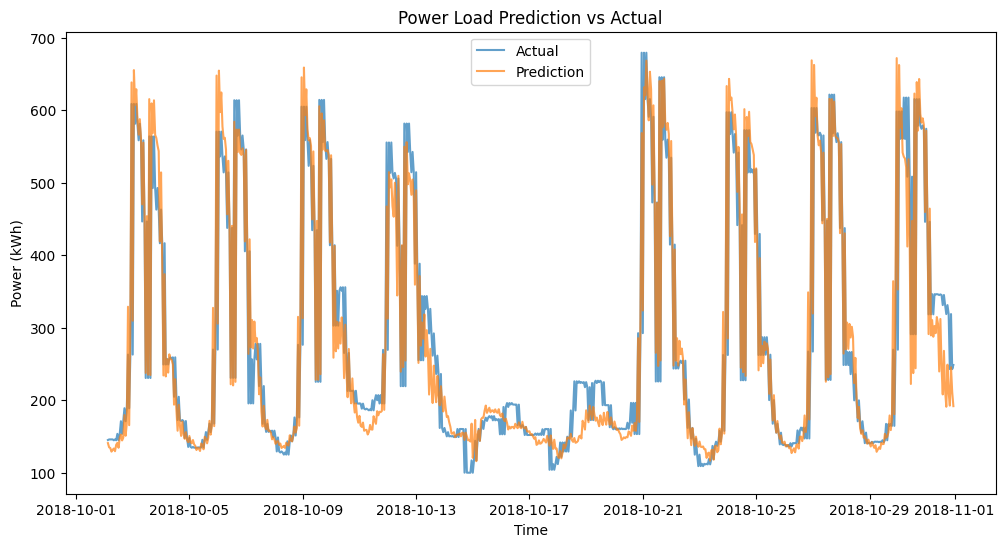

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 定義模型
class PowerPredictor(nn.Module):
    def __init__(self):
        super(PowerPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=100, num_layers=2, batch_first=True)  # 输入维度从1改为4
        self.fc = nn.Linear(100, 3)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 100).to(x.device)
        c0 = torch.zeros(2, x.size(0), 100).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# 讀取數據
data = pd.read_csv('../Dataset/BuildingEnergyLoad/BuildingConsumptionLoad.csv', parse_dates=['Date'], index_col='Date')

# 添加时间特征
data['Hour'] = data.index.hour
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month

# 归一化时间特征
data['Hour'] = data['Hour'] / 23.0  # 小时在0-23之间
data['DayOfWeek'] = data['DayOfWeek'] / 6.0  # 星期在0-6之间
data['Month'] = (data['Month'] - 1) / 11.0  # 月份在1-12之间

# 分割数据
train_data = data[(data.index >= '2018-07-01') & (data.index < '2018-10-01')].copy()
test_data = data[(data.index >= '2018-10-01') & (data.index < '2018-11-01')].copy()

train_mean = train_data['Total_Power(kWh)'].mean()
train_std = train_data['Total_Power(kWh)'].std()
train_data.loc[:, 'Total_Power(kWh)'] = (train_data['Total_Power(kWh)'] - train_mean) / train_std
test_data.loc[:, 'Total_Power(kWh)'] = (test_data['Total_Power(kWh)'] - train_mean) / train_std

# 更新create_sequences函数以包括时间特征
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size - 3):
        sequence = data.iloc[i:i+window_size][['Total_Power(kWh)', 'Hour', 'DayOfWeek', 'Month']].values
        target = data.iloc[i+window_size:i+window_size+3]['Total_Power(kWh)'].values
        sequences.append(sequence)
        targets.append(target)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

window_size = 24
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

class PowerDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PowerDataset(X_train, y_train)
test_dataset = PowerDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = PowerPredictor().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # 学习率调度

num_epochs = 100
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    scheduler.step()  # 更新学习率
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), './saved_models/power_predictor_with_more_features.pth')
model = PowerPredictor()
model.load_state_dict(torch.load('./saved_models/power_predictor_with_more_features.pth'))
model.cuda()
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        outputs = model(X_batch)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

predictions = predictions * train_std + train_mean
actuals = actuals * train_std + train_mean

mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error: {mse:.4f}")

min_length = min(len(actuals), len(predictions), len(test_data.index[window_size+3:]))
actuals = actuals[:min_length]
predictions = predictions[:min_length]
dates = test_data.index[window_size+3:][:min_length]

result_df = pd.DataFrame({
    'Date': dates,
    'Actual': actuals,
    'Prediction': predictions
})

plt.figure(figsize=(12, 6))
plt.plot(result_df['Date'], result_df['Actual'], label='Actual', alpha=0.7)
plt.plot(result_df['Date'], result_df['Prediction'], label='Prediction', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Power (kWh)')
plt.title('Power Load Prediction vs Actual')
plt.legend()
plt.show()





In [2]:
def predict_future(model, data, window_size, future_steps=3):
    model.eval()
    with torch.no_grad():
        sequence = data.iloc[-window_size:][['Total_Power(kWh)', 'Hour', 'DayOfWeek', 'Month']].values
        sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).cuda()
        predictions = model(sequence).cpu().numpy().flatten()
        predictions = predictions * train_std + train_mean  # 反归一化
    return predictions

new_data = test_data.copy()  # 示例数据
future_predictions = predict_future(model, new_data, window_size, future_steps=3)

print("未来三小时的预测负载为：", future_predictions)

未来三小时的预测负载为： [203.84998 177.4371  169.0877 ]
